In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Data Initializing**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/skripsi_chandra/ABSA_payment.csv')
df.head()

,review_token,Payment
0,"[7, 6, 2406, 19, 31, 34, 2407, 633, 5, 2, 361,...",0
1,"[7, 6, 70, 16, 73, 80, 13, 74, 6, 11, 88, 9, 1...",0
2,"[2, 1, 83, 6, 799, 18, 16, 9, 1, 3, 34, 5, 341...",0
3,"[1461, 688, 91, 821, 865, 68, 33, 74, 113, 315...",0
4,"[49, 46, 45, 41, 31, 18, 268, 37, 113, 65, 31,...",0


In [ ]:
print(type(df['Payment'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'str'>


In [ ]:
df['review_token'] = df['review_token'].map(lambda x: list(map(int, x[1:-1].split(', '))))

In [ ]:
print(type(df['Payment'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'list'>


In [ ]:
reviews = df[['review_token']]
labels = df['Payment']

## **Splitting Data and Applying Padding**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2275, 1) (487, 1) (488, 1) (2275,) (487,) (488,)


In [ ]:
x_train_pad = x_train['review_token']
x_val_pad = x_val['review_token']
x_test_pad = x_test['review_token']

In [ ]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

x_train = pad_sequences(x_train_pad, maxlen=100)
x_val = pad_sequences(x_val_pad, maxlen=100)
x_test = pad_sequences(x_test_pad, maxlen=100)

## **Modeling Initialization**

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np

embedding_matrix = np.load('/content/gdrive/MyDrive/skripsi_chandra/embedding_matrix.npy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(restore_best_weights=True, patience=3,
                               min_delta=0.01, monitor='val_loss')

**Hyperparameter tuning**
1. Filter Size [2], [2,3,4]
3. Dropout Rate [0.25, 0.5]
4. Learning Rate [0.001, 0.0001]

## **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNN(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNN,
    objective='val_accuracy',
    directory='payment_CNN',
    project_name='payment'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 35s]
val_accuracy: 0.977412760257721

Best val_accuracy So Far: 0.9794661402702332
Total elapsed time: 00h 03m 54s
Results summary
Results in payment_CNN/payment
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9794661402702332

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.977412760257721

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.975359320640564

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.9733059406280518

Trial 0002 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.001
Score: 0.9733059406280518

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9733059406280518

Trial 0006 summary
Hyperp

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2,3,4', 'dropout rate': 0.25, 'learning rate': 0.0001}

In [ ]:
model = build_CNN(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
36/36 [==============================] - 7s 140ms/step - loss: 2.0289 - accuracy: 0.9644 - val_loss: 1.6579 - val_accuracy: 0.9651
Epoch 2/50
36/36 [==============================] - 3s 85ms/step - loss: 1.5650 - accuracy: 0.9657 - val_loss: 1.5026 - val_accuracy: 0.9651
Epoch 3/50
36/36 [==============================] - 2s 55ms/step - loss: 1.4448 - accuracy: 0.9657 - val_loss: 1.3943 - val_accuracy: 0.9651
Epoch 4/50
36/36 [==============================] - 2s 64ms/step - loss: 1.3415 - accuracy: 0.9657 - val_loss: 1.2950 - val_accuracy: 0.9651
Epoch 5/50
36/36 [==============================] - 2s 40ms/step - loss: 1.2487 - accuracy: 0.9657 - val_loss: 1.2023 - val_accuracy: 0.9651
Epoch 6/50
36/36 [==============================] - 1s 23ms/step - loss: 1.1559 - accuracy: 0.9657 - val_loss: 1.1158 - val_accuracy: 0.9651
Epoch 7/50
36/36 [==============================] - 1s 27ms/step - loss: 1.0697 - accuracy: 0.9657 - val_loss: 1.0330 - val_accuracy: 0.9651
Epoch 8/50
3

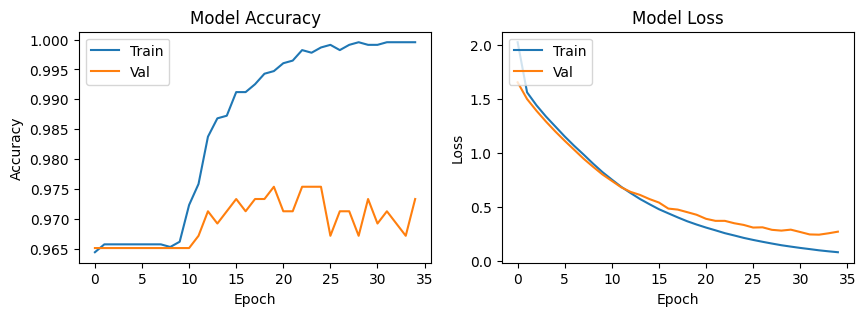

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('payment_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.8050847457627119
Macro-Average Recall: 0.7877482203072312
Macro-Average F1 Score: 0.7961374080143964


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       471
           1       0.62      0.59      0.61        17

    accuracy                           0.97       488
   macro avg       0.81      0.79      0.80       488
weighted avg       0.97      0.97      0.97       488



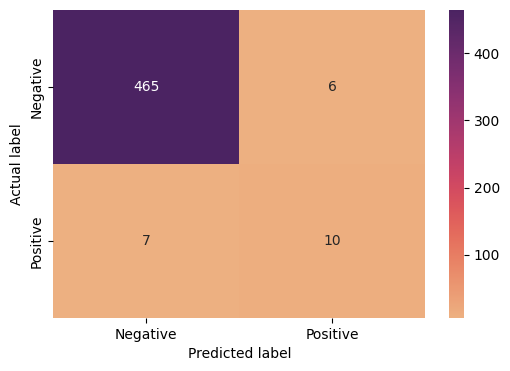

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

# **CNN-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNNLSTM(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(64))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNNLSTM,
    objective='val_accuracy',
    directory='payment_CNNLSTM',
    project_name='payment'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 37s]
val_accuracy: 0.9794661402702332

Best val_accuracy So Far: 0.9815195202827454
Total elapsed time: 00h 04m 07s
Results summary
Results in payment_CNNLSTM/payment
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9815195202827454

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9794661402702332

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9794661402702332

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9794661402702332

Trial 0000 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.001
Score: 0.977412760257721

Trial 0006 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.001
Score: 0.975359320640564

Trial 0002 summa

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2', 'dropout rate': 0.25, 'learning rate': 0.0001}

In [ ]:
model = build_CNNLSTM(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
36/36 [==============================] - 7s 125ms/step - loss: 2.0905 - accuracy: 0.9657 - val_loss: 1.8752 - val_accuracy: 0.9651
Epoch 2/50
36/36 [==============================] - 3s 68ms/step - loss: 1.6768 - accuracy: 0.9657 - val_loss: 1.5376 - val_accuracy: 0.9651
Epoch 3/50
36/36 [==============================] - 3s 87ms/step - loss: 1.4782 - accuracy: 0.9657 - val_loss: 1.4260 - val_accuracy: 0.9651
Epoch 4/50
36/36 [==============================] - 2s 58ms/step - loss: 1.3745 - accuracy: 0.9657 - val_loss: 1.3262 - val_accuracy: 0.9651
Epoch 5/50
36/36 [==============================] - 1s 35ms/step - loss: 1.2781 - accuracy: 0.9657 - val_loss: 1.2337 - val_accuracy: 0.9651
Epoch 6/50
36/36 [==============================] - 1s 23ms/step - loss: 1.1889 - accuracy: 0.9657 - val_loss: 1.1473 - val_accuracy: 0.9651
Epoch 7/50
36/36 [==============================] - 1s 30ms/step - loss: 1.1049 - accuracy: 0.9657 - val_loss: 1.0660 - val_accuracy: 0.9651
Epoch 8/50
3

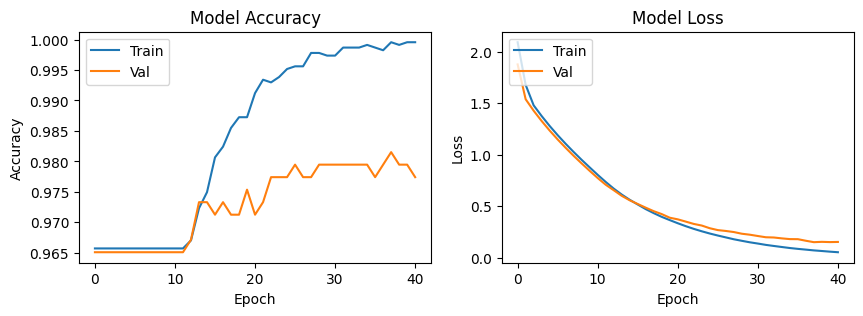

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('payment_CNNLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

16/16 [==============================] - 0s 3ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.8603241719520789
Macro-Average Recall: 0.8192831272636443
Macro-Average F1 Score: 0.8384533898305084


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       471
           1       0.73      0.65      0.69        17

    accuracy                           0.98       488
   macro avg       0.86      0.82      0.84       488
weighted avg       0.98      0.98      0.98       488



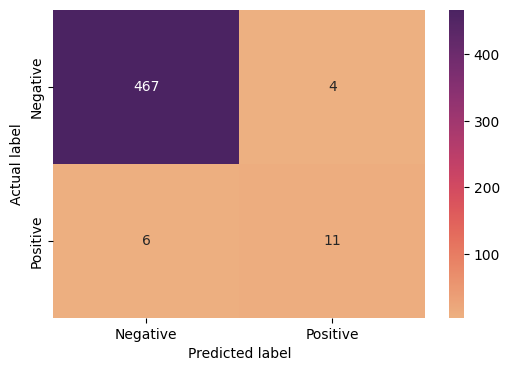

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()